# Query GFS Data from Thredds Server

What is a Thredds server?  
https://www.unidata.ucar.edu/software/tds/current/

In [1]:
from siphon.catalog import TDSCatalog

"""
    Siphon is a collection of Python utilities for downloading data from remote data services. 
    Much of Siphon’s current functionality focuses on access to data hosted on a THREDDS Data Server. 
    It also provides clients to a variety of simple web services.
    Link to documentation:https://unidata.github.io/siphon/latest/index.html
"""

In [2]:
"""
    Read a catalog from THREDDS Data Server
    First we construct a TDSCatalog instance pointing to our dataset of interest, in this case TDS’ “Best” virtual
    dataset for the GFS global 0.25 degree collection of GRIB files. This will give us a good resolution 
    for our map. This catalog contains a single dataset.
"""

best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
best_gfs.datasets

['Best GFS Quarter Degree Forecast Time Series']

In [3]:
best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()

In [4]:
query = ncss.query()

In [5]:
ncss.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_hybrid',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_p

In [6]:
from datetime import datetime

In [7]:
query.lonlat_box(north=43, south=35, east=260, west=249).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Temperature_surface')


var=Temperature_surface&time=2021-02-15T11%3A10%3A06.989941&west=249&east=260&south=35&north=43&accept=netcdf4

In [9]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

In [10]:
data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

list(data)

['Temperature_surface', 'LatLon_Projection']

In [12]:
temp_3d = data['Temperature_surface']
temp_3d

<xarray.DataArray 'Temperature_surface' (time1: 1, lat: 33, lon: 45)>
array([[[259.26642, 257.16644, ..., 250.06644, 248.06644],
        [258.96643, 258.46643, ..., 250.36642, 250.86642],
        ...,
        [272.66644, 273.66644, ..., 257.16644, 257.26642],
        [271.36642, 272.16644, ..., 255.96643, 255.56644]]], dtype=float32)
Coordinates:
    reftime1  (time1) datetime64[ns] ...
  * time1     (time1) datetime64[ns] 2021-02-15T12:00:00
  * lat       (lat) float32 43.0 42.75 42.5 42.25 42.0 ... 35.75 35.5 35.25 35.0
  * lon       (lon) float32 249.0 249.2 249.5 249.8 ... 259.2 259.5 259.8 260.0
Attributes:
    long_name:                      Temperature @ Ground or water surface
    units:                          K
    abbreviation:                   TMP
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-0-0_L1
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               1
    Grib2_Level_Desc:               Ground or water surface
    Grib2_Generating_Process_Type:  Forecast

In [13]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    raise ValueError('No time variable found for ' + var.name)

In [14]:
time_1d = find_time_var(temp_3d)
lat_1d = data['lat']
lon_1d = data['lon']
time_1d


<xarray.DataArray 'time1' (time1: 1)>
array(['2021-02-15T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    reftime1  (time1) datetime64[ns] 2021-02-15
  * time1     (time1) datetime64[ns] 2021-02-15T12:00:00
Attributes:
    standard_name:        time
    long_name:            GRIB forecast or observation time
    _CoordinateAxisType:  Time

In [16]:
import numpy as np
from netCDF4 import num2date
from metpy.units import units

In [17]:
# Reduce the dimensions of the data and get as an array with units
temp_2d = temp_3d.metpy.unit_array.squeeze()

# Combine latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables

/home/imke/miniconda3/envs/query_gfs/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


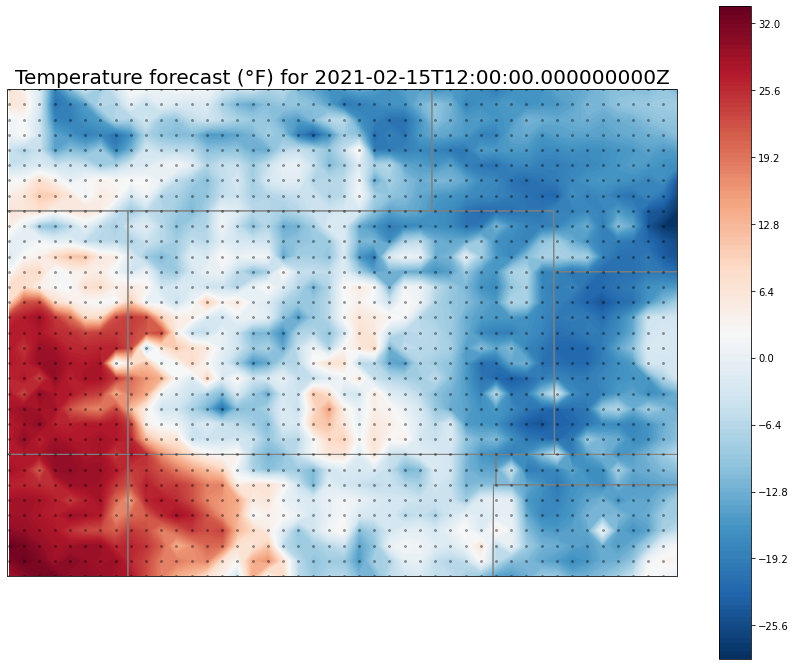

In [20]:
# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100.03, -111.03, 35, 43])

# Retrieve the state boundaries using cFeature and add to plot
ax.add_feature(cfeature.STATES, edgecolor='gray')

# Contour temperature at each lat/long
contours = ax.contourf(lon_2d, lat_2d, temp_2d.to('degF'), 200, transform=ccrs.PlateCarree(),
                       cmap='RdBu_r')
#Plot a colorbar to show temperature and reduce the size of it
fig.colorbar(contours)

# Make a title with the time value
ax.set_title(f'Temperature forecast (\u00b0F) for {time_1d[0].values}Z', fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), linestyle='none', marker='o',
        color='black', markersize=2, alpha=0.3, transform=ccrs.PlateCarree());